In [9]:
import torch
from torchgeo.trainers import SemanticSegmentationTask
from torchgeo.models import ResNet50_Weights
import geopandas as gpd
from torch.utils.data import Dataset
import rioxarray as rxr
import folium 
from typing import List 
import xarray as xr
import numpy as np
import tqdm

## Evalutaing a Pretrained Segmentation Model for nearshore Sargassum Segmentation

## Sargassum: An environmental disaster
In the Summer of 2011, the world changed and few realized. Massive amounts
of Pelagic Sargassum started washing ashore intermittently from the Eastern
Caribbean all the way to the west Coast of Africa. It began accumulating on
beaches and started causing a plethora of problems. When the sargassum accumulates 
on the beaches it begins to rot, this causes ecological damage, economic damage 
and even damage to nearby human populations as rotting sargassum releases hydrogen 
sulfide which can trigger respiratory and neurological issues. It quickly became 
clear that these unprecedented Sargassum Stranding events were part of a larger, 
complex and recurring event. Countries along Tropical Atlantic need
to address this problem as sargassum strandings are now an unwelcome reality.
For this reason it is necessary to have systems in place that can monitor, detect
and forecast Sargassum strandings. 

Although Sargassum can be detected in open ocean using standard remote sensing index based methods, these methods don't work in a nearshore environment. This is due to the fact that these
methods cannot discard the noise generated by near shore enviroments (other
vegetation, waves, seafloor, water turbidity, human activity). For this reason it is necessary to use machine learning in order to detect and monitor sargassum near the shore. Towards this end, we propose using a semantic segmentation model in order to detect sargassum nearshore. 

In this project we test whether sargassum segmentation is achievable using a pretrained semantic segmentation model. We use the torchgeo library (https://github.com/microsoft/torchgeo) that has various pretrained models that were pretrained on Sentinel-2 images. The dataset that we use for testing the performance of the model was manually annotated on Sentinel-2 images. The pretrained model that we used had terrible performance. The IOU over the dataset was 0.01. Therefore in order to make a model that can actually segment sargassum, we need to finetune a model. 


<img src="https://npr.brightspotcdn.com/dims4/default/1092d89/2147483647/strip/true/crop/800x533+0+0/resize/1760x1172!/format/webp/quality/90/?url=http%3A%2F%2Fnpr-brightspot.s3.amazonaws.com%2F37%2F4e%2Fd04ad1ac4010b5e980d7646b9030%2Fsargassum-blooms-atlantic-ocean-800x533.jpg">  <img/>

# Evaluation Dataset
- Dataset that was manually annotated
- Contains polygons that represent sargassum
- The segmentation dataset was made from these polygons by setting any pixel that overlaps with the sargassum polygon as 1 and every other pixel as 0 or background
- Annotations were made from the dates between 2020 and 2023

In [ ]:
def get_image_arr(sat_img: xr.DataArray, band_list: List[int]) -> np.ndarray:
  """
  Prepares image array in folium format
  """
  brightness = 20
  if len(band_list) == 1:
      return np.stack(sat_img[band_list[0]].values*(brightness))
  else :
      r = sat_img[band_list[0]].values*(brightness)
      g = sat_img[band_list[1]].values*(brightness)
      b = sat_img[band_list[2]].values*(brightness)
      return np.dstack([r,g,b])

def get_image_bounds(sat_img:any) -> List[List[int]]:
    """
    Returns image bounds in folium format
    """
    bounds = sat_img.rio.bounds()
    return [[bounds[1], bounds[0]], [bounds[3], bounds[2]]]


def get_folium_raster(img_path: str, band_list: List[int], opacity) -> folium.raster_layers.ImageOverlay:
    """
    Returns folium raster layer
    """
    sat_img = rxr.open_rasterio(img_path)
    img_arr = get_image_arr(sat_img, band_list)
    img_bounds = get_image_bounds(sat_img)
    return folium.raster_layers.ImageOverlay(
          name="sat_image",
          image=img_arr,
          bounds=img_bounds,
          opacity=opacity,
          interactive=True,
          cross_origin=False,
          zindex=1,
    )

In [11]:
polygon_gdf = gpd.read_file("../data/processed/segmentation/annotation_polygons")
polygon_gdf

,date,class_,spacecraft,azimuth_an,zenith_ang,time,path,mask_path,geometry
0,2019-03-19,sarg,None,None,None,None,../data/external/cache/1.tif,../data/processed/segmentation/mask/1.npy,"POLYGON ((-65.60511 18.09755, -65.60446 18.097..."
1,2019-03-19,sarg,None,None,None,None,../data/external/cache/2.tif,../data/processed/segmentation/mask/2.npy,"POLYGON ((-67.43775 18.02926, -67.43694 18.028..."
2,2019-03-19,sarg,None,None,None,None,../data/external/cache/3.tif,../data/processed/segmentation/mask/3.npy,"POLYGON ((-67.4517 18.02375, -67.45013 18.0241..."
3,2019-03-19,sarg,None,None,None,None,../data/external/cache/4.tif,../data/processed/segmentation/mask/4.npy,"POLYGON ((-67.44497 17.98242, -67.44629 17.982..."
4,2019-03-19,sarg,Sentinel-2A,126.951663694,28.583566353,1553008083000,../data/external/cache/5.tif,../data/processed/segmentation/mask/5.npy,"POLYGON ((-67.52178 17.94234, -67.52208 17.941..."
...,...,...,...,...,...,...,...,...,...
759,2023-05-02,sarg,Sentinel-2B,94.0391641180608,18.1694539649372,1683040085822,../data/external/cache/760.tif,../data/processed/segmentation/mask/760.npy,"POLYGON ((-66.46138 17.90547, -66.46112 17.904..."
760,2023-05-02,sarg,Sentinel-2B,94.0391641180608,18.1694539649372,1683040085822,../data/external/cache/761.tif,../data/processed/segmentation/mask/761.npy,"POLYGON ((-66.44212 17.88965, -66.44281 17.888..."
761,2023-05-02,sarg,Sentinel-2B,94.0391641180608,18.1694539649372,1683040085822,../data/external/cache/762.tif,../data/processed/segmentation/mask/762.npy,"POLYGON ((-66.23917 17.79332, -66.239 17.79221..."
762,2023-05-02,sarg,Sentinel-2B,94.0391641180608,18.1694539649372,1683040085822,../data/external/cache/763.tif,../data/processed/segmentation/mask/763.npy,"POLYGON ((-66.26441 17.78559, -66.26406 17.784..."


In [ ]:
#Converts gdf to geojson
labels_geojson =polygon_gdf.to_json()

#Creates map object
map_ = folium.Map(location=[17.9626, -67.075], zoom_start=12)

labels_layer = folium.GeoJson(data=labels_geojson, style_function=lambda x: {"fillColor": "orange"})
#Adds geojson layer to map
labels_layer.add_to(map_)

map_

## Model Eval

In [ ]:
torch.cuda.is_available()

False

In [26]:
#Used pretrained weights for resnet-50
weights = ResNet50_Weights.SENTINEL2_ALL_DINO
weights.value

Weights(url='https://hf.co/torchgeo/resnet50_sentinel2_all_dino/resolve/d7f14bf5530d70ac69d763e58e77e44dbecfec7c/resnet50_sentinel2_all_dino-d6c330e9.pth', transforms=AugmentationSequential(
  (Resize_0): Resize(output_size=256, p=1.0, p_batch=1.0, same_on_batch=True, size=256, side=short, resample=bilinear, align_corners=True, antialias=False)
  (CenterCrop_1): CenterCrop(p=1.0, p_batch=1.0, same_on_batch=True, resample=bilinear, cropping_mode=slice, align_corners=True, size=(224, 224), padding_mode=zeros)
  (Normalize_2): Normalize(p=1.0, p_batch=1.0, same_on_batch=True, mean=0, std=10000)
), meta={'dataset': 'SSL4EO-S12', 'in_chans': 13, 'model': 'resnet50', 'publication': 'https://arxiv.org/abs/2211.07044', 'repo': 'https://github.com/zhu-xlab/SSL4EO-S12', 'ssl_method': 'dino', 'bands': ['B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B8a', 'B9', 'B10', 'B11', 'B12']})

In [27]:
task = SemanticSegmentationTask(
    model="unet",
    backbone='resnet50',
    loss="ce",
    weights=weights,
    in_channels=13,
    num_classes=2,
    lr=0.001,
    patience=10,
    freeze_backbone=False,
)
model = task.model

In [28]:
#Segmentation dataset class
from typing import Any
from torchvision import transforms
import numpy as np
from torch.nn import functional as F
import torchvision.transforms as transforms


class SegmentationDataset(Dataset):
    def __init__(self, root_dir, use, transform=None):
        self.folder_path = root_dir
        self.transform = transform
        self.gdf = gpd.read_file(f"{self.folder_path}/annotation_polygons/annotation_polygons.shp")
        self.image_dict = self.image_in_memory()
        
    def __len__(self):
        return len(self.gdf.index) 
    
    def __getitem__(self, idx) -> Any:
        
        sat_img = self.image_dict[idx]["raster"]
        sat_img =  np.pad(sat_img.values, pad_width=((0, 1), (0, 0), (0, 0)), mode='constant', constant_values=0)
        if sat_img.shape[1] > 201:
            sat_img = sat_img[:,:-1, :]
        if sat_img.shape[2] > 201:
            sat_img = sat_img[:,:,:-1]
        mask_path = self.image_dict[idx]["mask_path"]
        mask = np.load(mask_path)



        if self.transform:
            sat_img = self.transform(sat_img.astype(np.float32))
            sat_img = F.normalize(sat_img, dim=0)
        return (sat_img, mask) 
    
    
    def image_in_memory(self):
        images = []
        for raster_path, mask_path in zip(self.gdf["path"], self.gdf["mask_path"]):
            sat_img = rxr.open_rasterio(raster_path)
            images.append({"raster":sat_img, "raster_path": raster_path, "mask_path": mask_path})
        return images



In [29]:
inference_dataset = SegmentationDataset(
    "../data/processed/segmentation", 
    "inference",
    transforms.Compose([torch.from_numpy,transforms.Resize(201)])
)

In [30]:

test_loader = torch.utils.data.DataLoader(dataset = inference_dataset,
                                     batch_size = 16,
                                     shuffle = True,
                                     num_workers=0)

In [31]:
device = torch.device('mps')     # Default CUDA device

In [32]:
def compute_iou_on_device(pred_mask, true_mask, device):
    # Ensure both masks are on the same device
    pred_mask = pred_mask.to(device)
    true_mask = true_mask.to(device)
    
    intersection = (pred_mask * true_mask).sum(dim=(1, 2))
    union = pred_mask.sum(dim=(1, 2)) + true_mask.sum(dim=(1, 2)) - intersection
    iou = intersection / (union + 1e-8)
    
    return iou.mean()

In [33]:
model.to(device)
model.eval()

ious = []

print("Starting inference...")
with torch.no_grad():
    for batch_idx, (rasters, mask) in tqdm.tqdm(enumerate(test_loader)):
        
        rasters = rasters.to(device) 
        logits = model(rasters)

        probabilities = torch.sigmoid(logits)
        pred_masks = (probabilities > 0.5).float()
        predicted_mask = torch.argmax(pred_masks, dim=1)

        mask = mask.to(device)
        intersection = (predicted_mask * mask).sum(dim=(1, 2))
        union = predicted_mask.sum(dim=(1, 2)) + mask.sum(dim=(1, 2)) - intersection
        
        iou = intersection / (union + 1e-8)
        ious.extend(iou.cpu().numpy())
        
        print("Mean Iou for batch", iou.mean())


print("Inference complete.")
mean_iou = np.mean(ious)
std_iou = np.std(ious)
print(mean_iou, std_iou)

Starting inference...


1it [00:00,  1.87it/s]

Mean Iou for batch tensor(0.0061, device='mps:0')


2it [00:00,  2.49it/s]

Mean Iou for batch tensor(0.0052, device='mps:0')


3it [00:01,  2.75it/s]

Mean Iou for batch tensor(0.0017, device='mps:0')


4it [00:01,  2.74it/s]

Mean Iou for batch tensor(0.0022, device='mps:0')


5it [00:01,  2.74it/s]

Mean Iou for batch tensor(0.0036, device='mps:0')


6it [00:02,  2.93it/s]

Mean Iou for batch tensor(0.0041, device='mps:0')


7it [00:02,  3.06it/s]

Mean Iou for batch tensor(0.0063, device='mps:0')


8it [00:02,  3.17it/s]

Mean Iou for batch tensor(0.0048, device='mps:0')


9it [00:03,  3.25it/s]

Mean Iou for batch tensor(0.0019, device='mps:0')


10it [00:03,  3.29it/s]

Mean Iou for batch tensor(0.0104, device='mps:0')


11it [00:03,  3.34it/s]

Mean Iou for batch tensor(0.0015, device='mps:0')


12it [00:03,  3.31it/s]

Mean Iou for batch tensor(0.0044, device='mps:0')


13it [00:04,  3.28it/s]

Mean Iou for batch tensor(0.0042, device='mps:0')


14it [00:04,  3.20it/s]

Mean Iou for batch tensor(0.0066, device='mps:0')


15it [00:04,  3.22it/s]

Mean Iou for batch tensor(0.0035, device='mps:0')


16it [00:05,  3.27it/s]

Mean Iou for batch tensor(0.0060, device='mps:0')


17it [00:05,  3.33it/s]

Mean Iou for batch tensor(0.0104, device='mps:0')


18it [00:05,  3.36it/s]

Mean Iou for batch tensor(0.0063, device='mps:0')


19it [00:06,  3.41it/s]

Mean Iou for batch tensor(0.0050, device='mps:0')


20it [00:06,  3.43it/s]

Mean Iou for batch tensor(0.0041, device='mps:0')


21it [00:06,  3.45it/s]

Mean Iou for batch tensor(0.0150, device='mps:0')


22it [00:06,  3.47it/s]

Mean Iou for batch tensor(0.0070, device='mps:0')


23it [00:07,  3.46it/s]

Mean Iou for batch tensor(0.0029, device='mps:0')


24it [00:07,  3.49it/s]

Mean Iou for batch tensor(0.0100, device='mps:0')


25it [00:07,  3.42it/s]

Mean Iou for batch tensor(0.0091, device='mps:0')


26it [00:08,  3.31it/s]

Mean Iou for batch tensor(0.0154, device='mps:0')


27it [00:08,  3.33it/s]

Mean Iou for batch tensor(0.0065, device='mps:0')


28it [00:08,  3.32it/s]

Mean Iou for batch tensor(0.0086, device='mps:0')


29it [00:09,  3.32it/s]

Mean Iou for batch tensor(0.0182, device='mps:0')


30it [00:09,  3.36it/s]

Mean Iou for batch tensor(0.0130, device='mps:0')


31it [00:09,  3.38it/s]

Mean Iou for batch tensor(0.0088, device='mps:0')


32it [00:09,  3.41it/s]

Mean Iou for batch tensor(0.0030, device='mps:0')


33it [00:10,  3.41it/s]

Mean Iou for batch tensor(0.0049, device='mps:0')


34it [00:10,  3.25it/s]

Mean Iou for batch tensor(0.0057, device='mps:0')


35it [00:10,  3.22it/s]

Mean Iou for batch tensor(0.0085, device='mps:0')


36it [00:11,  3.29it/s]

Mean Iou for batch tensor(0.0056, device='mps:0')


37it [00:11,  3.34it/s]

Mean Iou for batch tensor(0.0024, device='mps:0')


38it [00:11,  3.40it/s]

Mean Iou for batch tensor(0.0098, device='mps:0')


39it [00:11,  3.41it/s]

Mean Iou for batch tensor(0.0095, device='mps:0')


40it [00:12,  3.44it/s]

Mean Iou for batch tensor(0.0049, device='mps:0')


41it [00:12,  3.44it/s]

Mean Iou for batch tensor(0.0076, device='mps:0')


42it [00:12,  3.43it/s]

Mean Iou for batch tensor(0.0070, device='mps:0')


43it [00:13,  3.32it/s]

Mean Iou for batch tensor(0.0050, device='mps:0')


44it [00:13,  3.31it/s]

Mean Iou for batch tensor(0.0013, device='mps:0')


45it [00:13,  3.27it/s]

Mean Iou for batch tensor(0.0093, device='mps:0')


46it [00:14,  3.34it/s]

Mean Iou for batch tensor(0.0104, device='mps:0')


47it [00:14,  3.39it/s]

Mean Iou for batch tensor(0.0054, device='mps:0')


48it [00:14,  3.27it/s]

Mean Iou for batch tensor(0.0049, device='mps:0')
Inference complete.
0.0066299047 0.015142736


In [34]:
median_iou = np.median(ious)
min_iou = np.min(ious)
max_iou = np.max(ious)

excellent = np.sum(np.array(ious) >= 0.8)
good = np.sum((np.array(ious) >= 0.7) & (np.array(ious) < 0.8))
poor = np.sum(np.array(ious) < 0.5)

results = {
    'mean_iou': mean_iou,
    'std_iou': std_iou,
    'median_iou': median_iou,
    'min_iou': min_iou,
    'max_iou': max_iou,
    'excellent_samples': excellent,
    'good_samples': good,
    'poor_samples': poor,
    'total_samples': len(ious)
}

results

{'mean_iou': np.float32(0.0066299047),
 'std_iou': np.float32(0.015142736),
 'median_iou': np.float32(0.0),
 'min_iou': np.float32(0.0),
 'max_iou': np.float32(0.117219076),
 'excellent_samples': np.int64(0),
 'good_samples': np.int64(0),
 'poor_samples': np.int64(764),
 'total_samples': 764}

## Result visualization

In [35]:

index = 351
input_raster = inference_dataset.image_dict[index]["raster"]
input_raster.rio.to_raster("input_image.tif")
arr= inference_dataset[index][0].unsqueeze(0)

rasters = arr.to(device) 
model = model.to(device)
logits = model(rasters)
probabilities = torch.sigmoid(logits)
pred_masks = (probabilities > 0.5).float()
predicted_mask = torch.argmax(pred_masks, dim=1)

input_raster.isel(band=0, drop=True)
mask_raster_2d = input_raster.isel(band=0).copy(data=predicted_mask[0].to('cpu'))
mask_raster_2d = mask_raster_2d.astype(np.uint8)
mask_raster_2d.rio.to_raster("test_raster.tif")


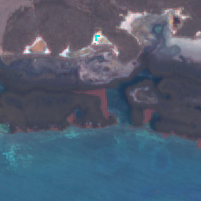
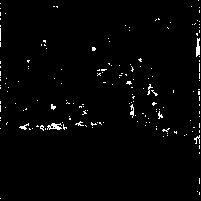

In [ ]:
#Creates map object
map_ = folium.Map(location=[17.9626, -67.075], zoom_start=12)

#Creates folium image overlay object
sat_img = get_folium_raster("input_image.tif", [4,2,1], 1)
#Adds overlay to image
sat_img.add_to(map_)

sat_img = get_folium_raster("test_raster.tif", [0], .5)
#Adds overlay to image
sat_img.add_to(map_)

map_

## Discussion

- Clearly the model is performing extremely poorly. I would've expected it to at least be able to capture some semantic information but that is not the case. That is probably due to an error in the evaluation pipeline. 
- The dataset also has various problems as the annotations for sargassum are sometimes very rough and there is only one annotation per image. This means that images that have multiple sargassum patches are not correctly labeled. 
- It is clear that in order to get a better working model it is necessary to finetune a segmentation model. 

